In [5]:
# %matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
from torch.utils import data
import pandas as pd
from random import randint

#torch.cuda.set_device(1)
torch.cuda.empty_cache()

#os.environ['CUDA_VISIBLE_DEVICES']='0' # pick GPU to use
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [6]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x




class PretrainedNet(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """
    def __init__(self):
        super(PretrainedNet, self).__init__()
        self.cnn = torchvision.models.resnet18()
        #self.cnn.fc = Identity()
        #for name, para in self.cnn1.named_parameters():
        #    if para.requires_grad:
        #        print (name)
        #alex_load.classifier[4] = nn.Linear(in_features = alex_load.classifier[1].out_features, out_features = 1000, bias = True)
        #self.cnn1.classifier[6] = nn.Linear(in_features = self.cnn1.classifier[4].out_features, out_features = 2, bias = True)
        
        
    def forward_once(self, x):
        output = self.cnn(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2



class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive
    

'''
class TestConfig():
    testing_table = pd.read_csv('/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/csv_files/all_images.csv')
    image_dir = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/data'
    scores_csv_file = pd.read_csv('/mnt/recsys/daniel/datasets/gan_masks_classify_cleft/cleft_lip_scores.csv')
'''
class TestConfig():
    testing_table = pd.read_csv('/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/csv_files/all_images_cropped.csv')
    image_dir = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/cropped/'
    scores_csv_file = pd.read_csv('/mnt/recsys/daniel/datasets/gan_masks_classify_cleft/cleft_lip_scores.csv')

In [7]:
class siamese_test_Dataset(torch.utils.data.Dataset):

    def __init__(self, patient_table, image_dir,scores_csv_file,  transform=None ):
        
        self.patient_table = patient_table
        self.image_dir = image_dir
        self.transform = transform
        self.epoch_size = len(self.patient_table)
        self.scroes_file = scores_csv_file
        if self.transform is None:
            self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.epoch_size

    def __getitem__(self, index):
        name_list = self.patient_table
        num_entries = len(name_list)
        label = 1

        while True:
            #random_image = random.choice(name_list).split('.')[0]+'.png' # note that processed images are all .png type, while patient_table has different types
            #img0 = None; img1 = None
            random_num = index
            
            random_row = name_list.iloc[random_num]
            patient_id = random_row['File_name']
            
            truth_image_name = patient_id + "_truth.png"
            fake_image_name = patient_id + '_out.png'
            #print (fake_image_name, truth_image_name)
            #print (patient_id[:-1])
            if (truth_image_name in os.listdir(os.path.join(self.image_dir, "truth"))) and (fake_image_name in os.listdir(os.path.join(self.image_dir,  "out"))):
                break
            elif fake_image_name in os.listdir(os.path.join(self.image_dir, "out")):
                print('attempted to get following image, but missing: ' + truth_image_name)
            elif truth_image_name in os.listdir(os.path.join(self.image_dir,  "truth")):
                print('attempted to get following image, but missing: ' + fake_image_name)
            else :
                print (fake_image_name)
        #print (truth_image_name, fake_image_name)
        #print (truth_image_name, fake_image_name)
        doctor_score = self.scroes_file.loc[self.scroes_file['Patient number'].isin([patient_id])]['Lip Score'].item()
        truth_img_dir = os.path.join(self.image_dir,  "truth")
        fake_img_dir = os.path.join(self.image_dir,  "out")
        img0 = Image.open(truth_img_dir +'/' +truth_image_name).convert("RGB")
        img1 = Image.open(fake_img_dir +'/' +fake_image_name).convert("RGB")
        #print (truth_image_name, fake_image_name)
        k1, k2 = img0.size, img1.size
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        #print (img1.shape)
        return img0, img1, patient_id, doctor_score, label




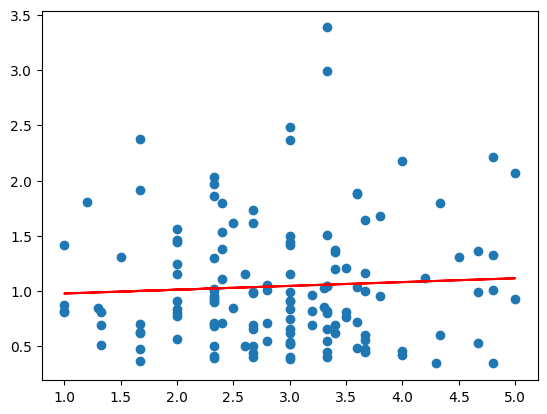

In [8]:

checkpoints_dir = "./ckpt/resnet_final"
test_epoch = 13

'''
checkpoints_dir = "./ckpt/resnet_same"
test_epoch = 25
'''
#test_model = SiameseNetworkbasic().cuda()
test_model = PretrainedNet().cuda()
test_model.load_state_dict(torch.load(checkpoints_dir + "/base_model_epoch{}.pth".format(test_epoch)))
test_model.eval()

test_transforms = transforms.Compose([ # pixel crop
    transforms.ToTensor()
])



testing_siamese_dataset = siamese_test_Dataset(patient_table = TestConfig.testing_table,
                                          image_dir = TestConfig.image_dir,
                                          scores_csv_file = TestConfig.scores_csv_file,
                                          transform = test_transforms)

scores_list = []
dissimilarity_score = []
patient_id = []
labels = [] 
x_axis = [x for x in range(138)]

#print(len(test_dataloader))

for test_cnt in range(138):
    x_0, x_1, p_id , score, label= testing_siamese_dataset[test_cnt]
    #print (x_0.shape)
    concatenated = torch.cat((x_0,x_1),0)
    output1,output2 = test_model(Variable(x_0).unsqueeze(0).cuda(),Variable(x_1).unsqueeze(0).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)


    scores_list.append(score)
    dissimilarity_score.append(euclidean_distance.item())
    #print (type(p_id))
    patient_id.append(p_id)
    labels.append(label)
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}_Score{:.2f}'.format(euclidean_distance.item()*1000,score.item() ))
    #print (euclidean_distance.item())
    #print (p_id, euclidean_distance.item())
dissimilarity_score = np.array(dissimilarity_score).astype(np.float64)
scores_list = np.array(scores_list).astype(np.float64)

plt.scatter(scores_list, dissimilarity_score)
a, b = np.polyfit(scores_list, dissimilarity_score,  1)
plt.plot(scores_list, a*scores_list+b, 'r-') 
plt.show()

In [5]:
cosine_dist.shape

NameError: name 'cosine_dist' is not defined

In [103]:
import io
import base64
import pandas as pd
from dash import Dash, dcc, html, Input, Output, no_update, callback
import plotly.express as px
import numpy as np
from PIL import Image

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
'''
remove_ids = ["2012_B12", "2012_19", "2011_20", "2011_30", "2010_35", "2012_31"]

loc_points = []
for named in remove_ids:
    idks = patient_id.index(named)
    loc_points.append(idks)

loc_points = []
for index, name in enumerate(patient_id):
    if name.split('.')[0].split('_')[1][0] == "B":
        loc_points.append(index)
        
labelsk = [value for index, value in enumerate(labels) if index not in loc_points]
scores_listk = [value for index, value in enumerate(scores_list) if index not in loc_points]
dissimilarity_scorek = [value for index, value in enumerate(dissimilarity_score) if index not in loc_points]
patient_idk = [value for index, value in enumerate(patient_id) if index not in loc_points]
'''
#df = pd.DataFrame(dict( doctor_score = scores_listk, pred_value = dissimilarity_scorek, patient_name= patient_idk, labels = labelsk))

df = pd.DataFrame(dict( doctor_score = scores_list, pred_value = dissimilarity_score, patient_name= patient_id, labels = labels))
grad, inter = np.polyfit(df["doctor_score"].tolist(), df["pred_value"].tolist(), 1)
x_val = list(np.arange(1, 5.1, 0.10))
y_val = [(element * grad) +inter for element in x_val]


cluster0 = df[df["labels"] == 1]

init_notebook_mode(connected=True)

trace1 = go.Scatter(x = cluster0["doctor_score"],
                    y = cluster0["pred_value"],
                    mode = "markers",
                    name = "cluster0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    ids= cluster0["patient_name"],
                   )
trace2 = go.Scatter(x = x_val,
                    y = y_val,
                    name = "slope",
                    line_shape='linear'
                   )
data = [trace1, trace2]


title = "Cleft Lip Doctor scores Vs Siamese Dissimilarity(Eucledian Distance between Image embedding)"

layout = dict(title = title,
              xaxis= dict(title= 'Doctor Scores',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Predicted Dissimilarity',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)
#fig1 = px.line(df, x="doctor_score", y="pred_value", title='Life expectancy in Canada')

# Set up the app now
app = Dash(__name__)

app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph-2-dcc", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip-2", direction='bottom'),
    ],
)

@callback(
    Output("graph-tooltip-2", "show"),
    Output("graph-tooltip-2", "bbox"),
    Output("graph-tooltip-2", "children"),
    Output("graph-tooltip-2", "direction"),

    Input("graph-2-dcc", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update, no_update
    #print (hoverData["points"][0] )
    #print (hoverData)
    img_name = hoverData["points"][0]["id"]
    
    # Load image with pillow
    ori_image_path = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/cropped/truth/'+ img_name +'_truth.png'
    im_ori = Image.open(ori_image_path).convert('RGB')
    gen_img_path = '/mnt/recsys/daniel/simase_network/dataset_256_0_pct_all/cropped/out/'+ img_name +'_out.png'
    im_gan = Image.open(gen_img_path).convert('RGB')
    
    image1_size = im_ori.size
    image2_size = im_gan.size
    new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
    new_image.paste(im_ori,(0,0))
    new_image.paste(im_gan,(image1_size[0],0))
    
    # dump it to base64
    buffer = io.BytesIO()
    new_image.save(buffer, format="jpeg")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/jpeg;base64, " + encoded_image

    # demo only shows the first point, but other points may also be available
    hover_data = hoverData["points"][0]
    bbox = hover_data["bbox"]
    

    # control the position of the tooltip
    y = hover_data["y"]
    direction = "bottom" if y > 1.5 else "top"

    children = [
        html.Img(
            src=im_url,
            style={"width": "300px"},
        ),
        html.P(img_name),
    ]
    
    return True, bbox, children, direction

if __name__ == "__main__":
    app.run(debug=True, port = 8055)

    
    #2011_20 2010_21 2012_21 2012_B4 2012_43 2010_40

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: 'id'

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: 'id'

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: 'id'

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: 'id'

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError: 'id'

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
KeyError

In [8]:
data_vals = df["pred_value"].tolist()

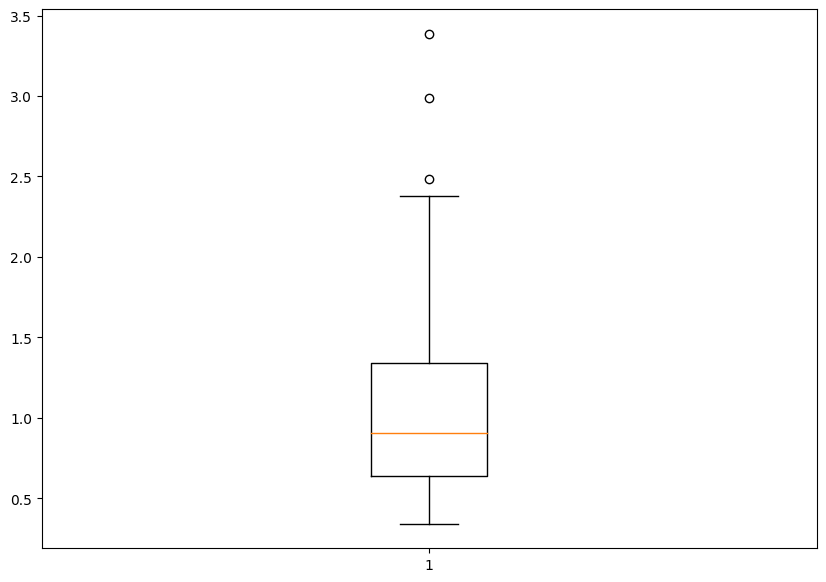

In [9]:

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset

data = data_vals
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
 
# show plot
plt.show()

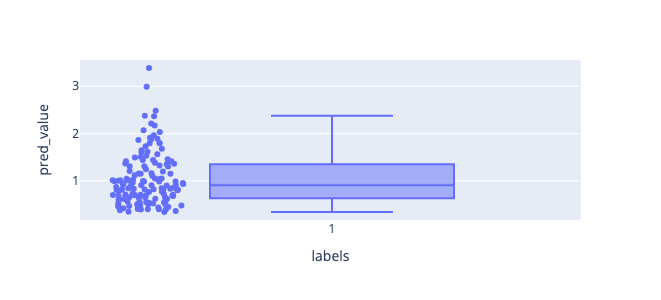

In [13]:
import plotly.express as px
df = df
fig = px.box(df,x="labels", y="pred_value", points="all", width=800, height=300)
fig.show()

In [9]:
import seaborn as sns
plt.figure(figsize=(16,3))
sns.set(font_scale=1.8)
ax = sns.boxplot(x=1./df['pred_value'],fliersize = 0, color = '#bdc3c7')
sns.stripplot(x=1./df['pred_value'], ax=ax, color = '#3498db', size=10)
plt.xlabel(None)
#plt.savefig("similarity_score.pdf", bbox_inches="tight")

NameError: name 'df' is not defined

<Figure size 1600x300 with 0 Axes>

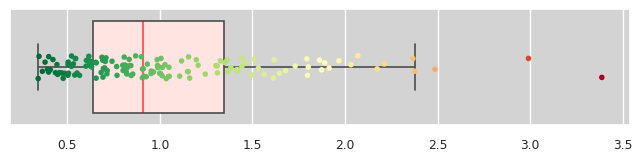

In [101]:
import seaborn as sns
plt.figure(figsize=(8,1.5))
#seaborn.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})

sns.set(font_scale=0.8, rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white'})
ax = sns.boxplot(x=df['pred_value'],fliersize = 0, linewidth=1.2, medianprops=dict(color="red", alpha=0.7),
            flierprops=dict(markerfacecolor="#000000", marker="d"), boxprops=dict(facecolor="mistyrose"))
sns.stripplot(x=df['pred_value'], ax=ax, hue=df['pred_value'],s = 4, legend=False,palette = 'RdYlGn_r', size=10)
plt.xlabel(None)

plt.savefig("similarity_score.pdf", bbox_inches="tight")

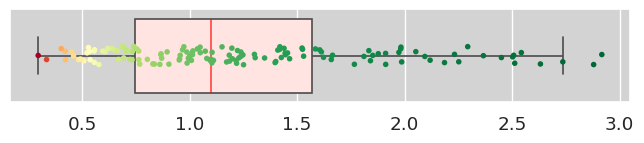

In [105]:
import seaborn as sns
plt.figure(figsize=(8,1.2))
#seaborn.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})

sns.set(font_scale=1.2, rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white'})
ax = sns.boxplot(x=1/df['pred_value'],fliersize = 0, linewidth=1.2, medianprops=dict(color="red", alpha=0.7),
            flierprops=dict(markerfacecolor="#707070", marker="d"), boxprops=dict(facecolor="mistyrose"))
sns.stripplot(x=1/df['pred_value'], ax=ax, hue=df['pred_value'],s = 4, legend=False,palette = 'RdYlGn_r', size=10)
plt.xlabel(None)

plt.savefig("similarity_score_inv.pdf", bbox_inches="tight")

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

In [ ]:
class PretrainedNet(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """
    def __init__(self):
        super(PretrainedNet, self).__init__()
        self.cnn = torchvision.models.resnet18()
        #self.cnn.fc = Identity()
        #for name, para in self.cnn1.named_parameters():
        #    if para.requires_grad:
        #        print (name)
        #alex_load.classifier[4] = nn.Linear(in_features = alex_load.classifier[1].out_features, out_features = 1000, bias = True)
        #self.cnn1.classifier[6] = nn.Linear(in_features = self.cnn1.classifier[4].out_features, out_features = 2, bias = True)
        
        
    def forward(self, x):
        output = self.cnn(x)
        return output

In [ ]:
grdcam_model = PretrainedNet().cuda()
grdcam_model.load_state_dict(torch.load(checkpoints_dir + "/base_model_epoch{}.pth".format(test_epoch)))
grdcam_model.eval()

In [ ]:


rgb_img = np.array(Image.open(os.path.join(TestConfig.image_dir , 'out',p_id+"_out.png")))/255.0
target_layers = [grdcam_model.cnn.layer4[1].conv2]
input_tensor = Variable(x_0).unsqueeze(0).cuda()



cam = GradCAM(model=grdcam_model, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(2)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
plt.imshow(visualization)

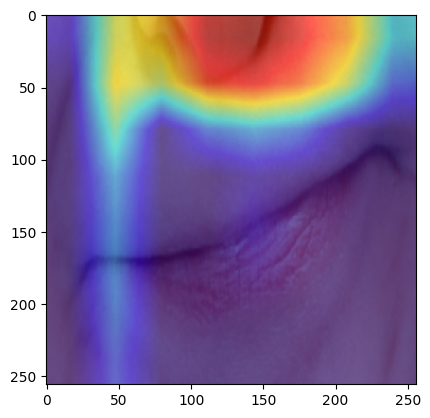

In [39]:
np.unique(np.array(rgb_img)/255.0)

array([0.04313725, 0.04705882, 0.05098039, 0.05490196, 0.05882353,
       0.0627451 , 0.06666667, 0.07058824, 0.0745098 , 0.07843137,
       0.08235294, 0.08627451, 0.09019608, 0.09411765, 0.09803922,
       0.10196078, 0.10588235, 0.10980392, 0.11372549, 0.11764706,
       0.12156863, 0.1254902 , 0.12941176, 0.13333333, 0.1372549 ,
       0.14117647, 0.14509804, 0.14901961, 0.15294118, 0.15686275,
       0.16078431, 0.16470588, 0.16862745, 0.17254902, 0.17647059,
       0.18039216, 0.18431373, 0.18823529, 0.19215686, 0.19607843,
       0.2       , 0.20392157, 0.20784314, 0.21176471, 0.21568627,
       0.21960784, 0.22352941, 0.22745098, 0.23137255, 0.23529412,
       0.23921569, 0.24313725, 0.24705882, 0.25098039, 0.25490196,
       0.25882353, 0.2627451 , 0.26666667, 0.27058824, 0.2745098 ,
       0.27843137, 0.28235294, 0.28627451, 0.29019608, 0.29411765,
       0.29803922, 0.30196078, 0.30588235, 0.30980392, 0.31372549,
       0.31764706, 0.32156863, 0.3254902 , 0.32941176, 0.33333

In [10]:
import dlib
from PIL import Image
img = Image.open('00933.png')
import matplotlib.pyplot as plt
import numpy as np

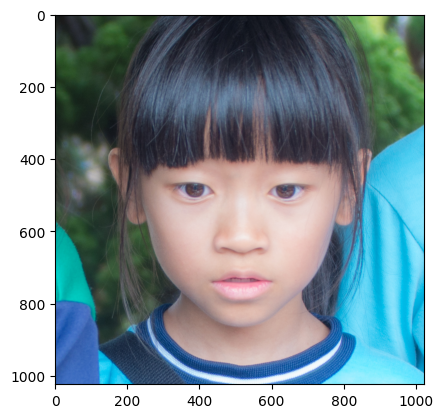

In [5]:
plt.imshow(img)

In [16]:
from imutils import face_utils
import cv2
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [11]:
img = np.array(img)
rects = detector(img, 0)

In [22]:
shape = predictor(img, rects[0])
shape = face_utils.shape_to_np(shape)

# Draw on our image, all the finded cordinate points (x,y) 
for (x, y) in shape:
    cv2.circle(img, (x, y), 2, (255, 0, 0), 6)

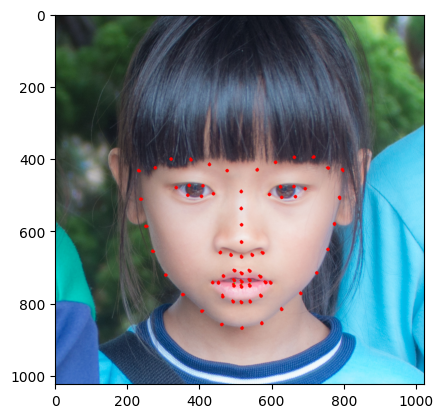

In [23]:
plt.imshow(img)

In [26]:
cv2.imwrite('out_img.jpg', cv2.Color(img, cv2.COLOR_BGR2RGB))

AttributeError: module 'cv2' has no attribute 'Color'

In [27]:
cv2.imwrite('out_img.jpg', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

True